In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
import time
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle
import gzip
import queue as qe
import time
import networkx as nx
from sklearn.linear_model import LinearRegression

# Práctica 1

## Parte 1

In [2]:
l = [[0, 10, 1, np.inf],
[np.inf, 0, 1, np.inf],
[np.inf, np.inf, 0, 1 ],
[np.inf, 1, np.inf, 0]]
m_g = np.array(l)

In [3]:
d_g = {0: {1: 10, 2:1}, 1: {2: 1},
2: {3: 1}, 3: {1: 1}}

In [4]:
m_g,d_g

(array([[  0.,  10.,   1.,  inf],
        [ inf,   0.,   1.,  inf],
        [ inf,  inf,   0.,   1.],
        [ inf,   1.,  inf,   0.]]),
 {0: {1: 10, 2: 1}, 1: {2: 1}, 2: {3: 1}, 3: {1: 1}})

In [5]:
'''
n_nodes: numero de nodos
sparse_factor: proporcion de ramas
max_weight: peso maximo
'''
def rand_matr_pos_graph(n_nodes, sparse_factor, max_weight=50., decimals=0):
    l = np.full((n_nodes,n_nodes),np.inf)
    branch_number = int(sparse_factor*(n_nodes)*(n_nodes-1))
    for count in range(0,branch_number):
        condition = True
        while(condition):
            i = random.randint(0,n_nodes-1)
            j = random.randint(0,n_nodes-1)
            if(j!=i and l[i,j] == np.inf):
                condition = False         
        weight = random.randint(1,max_weight)
        l[i,j] = weight
    #np.fill_diagonal(l,0)
    return l               
    

In [6]:
def cuenta_ramas(m_g):
    n_nodes = m_g.shape[0]
    branches = 0
    for i in range(0,n_nodes):
        for j in range(0,n_nodes):
            if ((m_g[i,j] != np.inf) and i != j):
                branches+=1
    return branches

print()

In [7]:
def m_g_sparse_factor(m_g):
    n_nodes = m_g.shape[0]
    return cuenta_ramas(m_g)/(n_nodes*(n_nodes-1))

def check_sparse_factor(n_grafos,n_nodes,sparse_factor):
    sparses = []
    for i in range(0,n_grafos):
        m = rand_matr_pos_graph(n_nodes,sparse_factor)
        sparses.append(m_g_sparse_factor(m))
    return np.mean(sparses)    

In [8]:
def m_g_2_d_g(m_g):
    n_nodes = m_g.shape[0]
    d_g = {}
    for i in range(0,n_nodes):
        d_g[i] = {}
        for j in range(0,n_nodes):
            if(m_g[i,j] != np.inf):
                d_g[i][j] = m_g[i,j]
    return d_g

In [9]:
def d_g_2_m_g(d_g):
    n_nodes = len(d_g.keys())
    m_g = np.full((n_nodes,n_nodes),np.inf)
    for node in d_g:
        for branch in d_g[node]:
            m_g[node,branch] = d_g[node][branch]
    return m_g

In [10]:
def save_object(obj, f_name="obj.pklz", save_path="."):
    f = gzip.open(save_path+"/"+f_name,"wb")
    pickle.dump(obj,f)
    f.close()

def read_object(f_name, save_path="."):
    f = gzip.open(save_path+"/"+f_name,"rb")
    obj = pickle.load(f)
    f.close()
    return obj

In [11]:
def d_g_2_TGF(d_g,f_name):
    f = open(f_name,"w")
    for node in d_g.keys():
        f.write("%d\n" % node)
    f.write("#\n")
    for node in d_g.keys():
        for branch in d_g[node]:
            #f.write("%d %d %l\n" % (node, branch, d_g[node][branch]))
            f.write("{0} {1} {2}\n".format(node, branch, d_g[node][branch]))
    f.close()

In [60]:
def TGF_2_d_g(f_name):
    f = open(f_name,"r")
    line = f.read().split('\n')
    d_g = {}
    aux = []
    for c in line:
        aux.append(c)
        if(c == "#"):
            break
        #d_g[int(c)] = {}
        n = int(c)
        d_g.update({n:{}})
        
    #splitted = line.strip("\n").split(" ")
    line = line[len(aux):-1]
    for c in line:
        splitted = c.split(" ")
        #d_g[int(splitted[0])][int(splitted[1])] = float(splitted[2])
        p1 = int(splitted[1])
        p2 = float(splitted[2])
        d_g[int(splitted[0])].update({p1:p2})
    f.close()
    return d_g
           


n_nodes = 5
sparse = 0.5
m = rand_matr_pos_graph(n_nodes,sparse)
print(m)
dicc = m_g_2_d_g(m)
print("[m_g_2_d_g(m)]:\n", dicc)
dicc[0][2] = 0.5
d_g_2_TGF(dicc,"pepitogrillo.txt")
save_object(dicc)
print("[RES]:\n", TGF_2_d_g("pepitogrillo.txt"))

[[ inf  31.  13.  inf  inf]
 [ 44.  inf  inf  inf  inf]
 [ 22.  inf  inf  inf  24.]
 [ 34.  14.   1.  inf  inf]
 [ inf  38.  36.  inf  inf]]
[m_g_2_d_g(m)]:
 {0: {1: 31.0, 2: 13.0}, 1: {0: 44.0}, 2: {0: 22.0, 4: 24.0}, 3: {0: 34.0, 1: 14.0, 2: 1.0}, 4: {1: 38.0, 2: 36.0}}
[RES]:
 {0: {1: 31.0, 2: 0.5}, 1: {0: 44.0}, 2: {0: 22.0, 4: 24.0}, 3: {0: 34.0, 1: 14.0, 2: 1.0}, 4: {1: 38.0, 2: 36.0}}


### Cuestiones

**Describir que se entiende por serializar un objeto Python.**

Serializar un objeto es el proceso de convertirlo a un formato específico mediante el cual pueda ser almacenado en disco de forma persistente y posteriormente cargado desde el fichero en el mismo estado en el que se guardó.

**json es otro formato de serialiacion de objetos. Comentar brevemente posibles diferencias entre pickle y json.**

La diferencia principal entre pickle y json es que pickle guarda los objetos en binario mientras que json guarda los objetos de forma legible mediante atributos->valor.
Un ejemplo de pickle para guardar la lista [1,2,3,4] sería:
```
�]q (KKKKe.
```
Y en JSON podría ser por ejemplo
```json
{
    lista: [1,2,3,4]
}
```

**¿Que ventajas e inconvenientes tendrían las funciones pickle sobre las construidas mediante el formato TGF? Responder algo pertinente y no con lugares comunes.**

    * Ventajas:
        1. La escritura y lectura es más rápida ya que se escribe el objeto directamente y no es necesario procesarlo para su escritura ni lectura.
        2. La forma de escritura y lectura de pickle es mucho más sencilla que la escritura-lectura en formato TGF, ya que para escribir y leer en este formato es necesario procesar el grafo e ir escribiendo en el formato adecuado mientras que pickle vuelca el objeto directamente.
        3. El formato de pickle es más seguro ya que al guardar la información en binario, no puede ser accedida por cualquier persona en cualquier momento.

    * Desventajas: 
        1. No es legible para personas el fichero escrito, por lo que para leerlo es necesario utilizar la librería pickle junto con un script de Python.
        2. El formato TGF ocupa menos espacio en disco que el formato pickle (para un mismo grafo pequeño de ejemplo, el objeto en formato TGF ocupa 107 bytes y en formato pickle y comprimido, ocupa 272 bytes) . Esto para grafos grandes y a nivel de rendimiento, podría suponer un gran problema de almacenamiento.
        3. Pickle, al ser una librería de Python, hace que los grafos volcados a través de ella no sean accesibles a través de programas escritos en otros lenguajes.


In [13]:
def dijkstra_d(d_g, u):
    d_dist = {}
    d_prev = {}
    
    dist = np.full(len(d_g.keys()), np.inf)
    visitados = np.full(len(d_g.keys()), False)
    n_padre = np.full(len(d_g.keys()), None)
    
    cola = qe.PriorityQueue()
    dist[u] = 0.0
    cola.put((0.0, u))
    
    while not cola.empty():
        pos = cola.get()
        visitados[pos[1]] = True
        
        for key,value in d_g[pos[1]].items():
            if dist[key] > dist[pos[1]] + value:
                dist[key] = dist[pos[1]] + value
                n_padre[key] = pos[1]
                cola.put((dist[key], key))
   
    for n in range(len(dist)):
        d_dist.update({n:dist[n]})
        d_prev.update({n:n_padre[n]})
        
    return d_dist, d_prev

def dijkstra_m(m_g,u):
    d_dist = {}
    d_prev = {}
    
    n_nodos = m_g.shape[0]
    dist = np.full(n_nodos, np.inf)
    visitados = np.full(n_nodos, False)
    n_padre = np.full(n_nodos, None)
    
    cola = qe.PriorityQueue()
    dist[u] = 0.0
    cola.put((0.0, u))
    
    while not cola.empty():
        pos = cola.get()
        nodo = pos[1]
        visitados[nodo] = True
        
        for adyacente in range(0,n_nodos):
            if(m_g[nodo,adyacente] != np.inf):
                if dist[adyacente] > dist[nodo] + m_g[nodo,adyacente]:
                    dist[adyacente] = dist[nodo] + m_g[nodo,adyacente]
                    n_padre[adyacente] = nodo
                    cola.put((dist[adyacente], adyacente))
            
    for n in range(len(dist)):
        d_dist.update({n:dist[n]})
        d_prev.update({n:n_padre[n]})
        
    return d_dist, d_prev


d_g = {0: {1: 10, 2:1}, 1: {2: 1,3:2}, 2: {3: 1}, 3: {1: 1, 0:1}}
m_g = d_g_2_m_g(d_g)

d,p = dijkstra_d(d_g,0)
print(dijkstra_m(m_g,0))


({0: 0.0, 1: 3.0, 2: 1.0, 3: 2.0}, {0: None, 1: 3, 2: 0, 3: 2})


In [57]:
def min_paths(d_prev):
    inicial = -1
    for key in d_prev:
        if(d_prev[key] == None):
            inicial = key
    if(inicial == -1):
        raise Exception("La lista de padres no contiene un nodo inicial con padre = None")
    d_paths = {}
    for nodo in d_prev:
        path = []
        condicion = True
        
        nodo_padre = nodo
        while(condicion):
            if(nodo_padre == None):
                path.reverse()
                d_paths[nodo] = path
                condicion = False
            else:
                path.append(nodo_padre)
                nodo_padre = d_prev[nodo_padre]
    return d_paths

In [58]:
mm = np.array([
[0, 1., 1., 1., np.inf, np.inf, np.inf],
[np.inf, 0., np.inf, 1., 1., np.inf, np.inf],
[np.inf, np.inf, 0., np.inf, np.inf, 1., np.inf],
[np.inf, np.inf, 1., 0., np.inf, 1., 1.],
[np.inf, np.inf, np.inf, 1., 0., np.inf, 1.],
[np.inf, np.inf, np.inf, np.inf, np.inf, 0., 1.],
[np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 0.]    
])

dd = m_g_2_d_g(mm)
d, p = dijkstra_d(dd, 0)
min_paths(p)

{0: [0],
 1: [0, 1],
 2: [0, 2],
 3: [0, 3],
 4: [0, 1, 4],
 5: [0, 2, 5],
 6: [0, 3, 6]}

In [69]:
def time_dijkstra_m(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            m_g = rand_matr_pos_graph(n_nodos, sparse_factor)
            diccionario_grafos[n_nodos].append(m_g)
   
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                dijkstra_m(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin)

    return lista_tiempos
            
print(time_dijkstra_m(100,1,5,1))
    

[0.0023529529571533203, 0.004708051681518555, 0.008084297180175781, 0.012869119644165039, 0.019173145294189453]


In [68]:
def time_dijkstra_d(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            d_g = m_g_2_d_g(rand_matr_pos_graph(n_nodos, sparse_factor))
            diccionario_grafos[n_nodos].append(d_g)
           
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                dijkstra_d(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin)

    return lista_tiempos
            
print(time_dijkstra_d(100,1,5,1))

[0.0023810863494873047, 0.00474095344543457, 0.007714509963989258, 0.012165069580078125, 0.0171661376953125]


In [32]:
def d_g_2_nx_g(d_g):
    l_e = []
    g = nx.DiGraph()
    
    for key,value in d_g.items():
        for key2,value2 in value.items():
            l_e.append((key,key2,value2))
            
    g.add_weighted_edges_from(l_e)
    return g

In [46]:
def nx_g_2_d_g(nx_g):
    d_g = {}
    
    for count in nx_g.nodes():
        for key,value in nx_g[count].items():
            if d_g.get(count) == None:
                d_g.update({count:{}})
            for key2,value2 in value.items():
                d_g[count][key]=value2
    
    return d_g

d_g = {0: {1: 10, 2:1}, 1: {2: 1},
2: {3: 1}, 3: {1: 1}}

print(d_g)

nxg = d_g_2_nx_g(d_g)

d_g2 = nx_g_2_d_g(nxg)
print(d_g2)
            

{0: {1: 10, 2: 1}, 1: {2: 1}, 2: {3: 1}, 3: {1: 1}}
{0: {1: 10, 2: 1}, 1: {2: 1}, 2: {3: 1}, 3: {1: 1}}


In [72]:
def time_dijkstra_nx(n_graphs, n_nodes_ini, n_nodes_fin, step, sparse_factor=.25):
    diccionario_grafos = {}
    lista_tiempos = []
    for i in range(0,n_graphs):
        for n_nodos in range(n_nodes_ini,n_nodes_fin+1,step):
            if(n_nodos not in diccionario_grafos.keys()):
                diccionario_grafos[n_nodos] = []
            m_g = rand_matr_pos_graph(n_nodos, sparse_factor)
            g = nx.from_numpy_matrix(m_g)
            diccionario_grafos[n_nodos].append(g)
            
    for n_nodos in diccionario_grafos.keys():
        
        tiempo_ini = time.time()
        for i in range(0,n_graphs):
            for nodo in range(0,n_nodos):
                nx.single_source_dijkstra(diccionario_grafos[n_nodos][i],nodo)
        tiempo_fin = time.time()-tiempo_ini
        lista_tiempos.append(tiempo_fin)

    return lista_tiempos


print(time_dijkstra_nx(10, 1, 5, 1))
    
    
    

[5.245208740234375e-05, 0.00011444091796875, 0.0002536773681640625, 0.0005030632019042969, 0.0008680820465087891]


In [112]:
def fit_plot(l, func_2_fit, size_ini, size_fin, step,legend):
    l_func_values =[i*func_2_fit(i) for i in range(size_ini, size_fin+1, step)]
    
    lr_m = LinearRegression()
    X = np.array(l_func_values).reshape( len(l_func_values), -1 )
    lr_m.fit(X, l)
    y_pred = lr_m.predict(X)
    
    
    trueLegend="True " + legend
    predictedLegend = "Pred. " + legend
    
    plt.plot(l, '*',label=trueLegend)
    plt.plot(y_pred, '-',label=predictedLegend)
    plt.legend()
    plt.title("Time comparative")
    plt.xlabel("Number of nodes")
    plt.ylabel("Time*number of nodes (seconds)")

def n2_log_n(n):
    return n**2. * np.log(n)

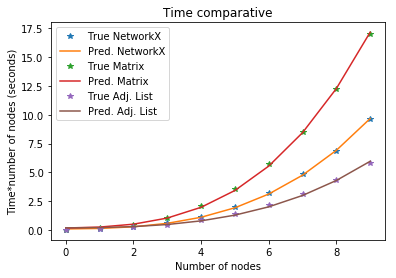

In [114]:
n_graphs=20
n_nodes_ini=10 
n_nodes_fin=100
step=10
sparse_f= 0.25
l_t_nx = time_dijkstra_nx(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
l_t_m = time_dijkstra_m(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)
l_t_d = time_dijkstra_d(n_graphs=n_graphs, n_nodes_ini=n_nodes_ini, 
                          n_nodes_fin=n_nodes_fin, step=step, sparse_factor=sparse_f)

fit_plot(l_t_nx, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="NetworkX")
fit_plot(l_t_m, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="Matrix")
fit_plot(l_t_d, n2_log_n, size_ini=n_nodes_ini, size_fin=n_nodes_fin, step=step,legend="Adj. List")